# Custom Trained Text Classification with DistilBERT
* Notebook by Adam Lang
* Date: 10/4/2024

# What we are doing
* Building a "Food vs. NOT Food text classification" application.
* This project was from the ZTM academy course with Mr. Daniel Bourke the PyTorch guru. All credit goes to him, if anyone wants to learn anything PyTorch he is the person to learn from. This is 100% practical material that can be utilized in your own projects and in your job. Thank you Mr. Daniel Bourke!

## Import Libraries



In [1]:
## install dependencies (google colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  ## after installed reimport
  import datasets, evaluate, accelerate
  import gradio as gr


## other imports
import random ##sampling datasets
import numpy as np
import pandas as pd

## deep learnining/ML imports
import torch
import transformers


## print versions
print(f"Using transformers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63

# Getting a dataset
* This is the dataset we are going to use: https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions
* We are going to build a "Food vs. NOT food text classification" application.
* So the dataset we are using is a labeled dataset from huggingface.
* Thus, this is a supervised learning problem.

#### Tips on where to get text classification datasets
  * Huggingface datasets
  * Papers with Code
  * Kaggle

### How the dataset was generated
* The dataset was generated using the Mistral LLM with prompting.
* This is a great example of how to get synthtetic labeled data for machine learning.
  * "Bootstrap a binary classification dataset"

### Loading data from Huggingface

In [2]:
## importing dataset
from datasets import load_dataset

## dataset load
dataset = load_dataset(path='mrdbourke/learn_hf_food_not_food_image_captions')
dataset

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [3]:
## features in data
dataset.column_names

{'train': ['text', 'label']}

By default if you upload your own dataset to HF, it will be a train dataset as we see above.

In [4]:
# access training split
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [5]:
## dataset samples -- need the 'train' key
dataset['train'][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

### Random Samples of dataset

In [6]:
import random

## random indices
random_indexs = random.sample(range(len(dataset['train'])), 5)
print(random_indexs)

## index random samples
random_samples = dataset['train'][random_indexs]

## zip text and label together
print(f"[INFO] Random samples from dataset:\n")
for text, label in zip(random_samples['text'], random_samples['label']):
  print(f"Text: {text} | Label: {label}")

[161, 69, 196, 164, 106]
[INFO] Random samples from dataset:

Text: Set of measuring cups nested in a drawer | Label: not_food
Text: A slice of veggie pizza loaded with colorful and nutritious vegetables | Label: food
Text: Friends having a barbecue in the backyard while pets play nearbyA collection of cleaning products under the sink | Label: not_food
Text: Sushi roll with premium ingredients like uni or wagyu beef. | Label: food
Text: Set of potholders stored in a drawer | Label: not_food


In [7]:
# Get unique label values
dataset['train'].unique('label')

['food', 'not_food']

In [8]:
## check count of each label
from collections import Counter

##setup counter
Counter(dataset['train']['label'])

Counter({'food': 125, 'not_food': 125})

Observation
* Notice the dataset is 100% balanced because the dataset was synthetically generated.
* This is something to take note of, if you ever need to enhance your dataset in the future, you can use an LLM to do so.
* As we know in machine learning, a model will not perform well on classification tasks if the target classification variables are not well balanced.
  * Obviously there are statistical methods to up or down sample or use SMOTE to correct this, but with the advent of LLMs it is another great tool to use.

In [9]:
## turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset['train'])
food_not_food_df.sample(7)

,text,label
217,"A platter of raw vegetables, including broccol...",food
39,A bowl of sliced cucumbers with a sprinkle of ...,food
148,"Playing video games in the living room, a boy ...",not_food
229,Sushi platter featuring a rainbow of colors wi...,food
127,"Zucchini in a bowl, sprinkled with basil and s...",food
76,Set of bowls stacked on a shelf,not_food
181,"A steaming bowl of fiery chicken curry, infuse...",food


In [10]:
## value counts of labels
food_not_food_df['label'].value_counts()

,count
label,
food,125
not_food,125


Summary:
* Again we can see the target variable is well balanced.

# Preparing data for text classification
* Main steps to take:
1. Map labels to ids
2. Train/Test split
3. Tokenization

* These steps do not have to be in this exact order.

* Before we do any of that, we need to create a **mapping from labels to numbers.**

* Why do we need to map labels to numbers?
  * Tokenization turns text into numbers.
  * Mapping labels to numbers is the same thing.

## 1. Creating a mapping from labels to numbers

Manual method to create labels
* This is only efficient for binary classification or tasks with a few labels

In [11]:
## map labels to numeric values - dictionaries
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

## print mapping
print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


Programmatic way to create labels
* This is more efficient when you might have 100s or even 1000s of labels to map.

In [12]:
## create mappings programmatically --> [::,-1] reverse
id2label = {idx: label for idx, label in enumerate(dataset['train'].unique('label')[::-1])}
label2id = {label: idx for idx, label in id2label.items()}
## print both results
print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


Another way to do this below:

In [13]:
## empty dict
id2label = {}
## loop over idx,label
for idx, label in enumerate(dataset['train'].unique('label')[::-1]):
  print(idx, label)
  id2label[idx] = label

0 not_food
1 food


Now we need to map the labels to 0 or 1

In [14]:
## create function map label --> 0 or 1
def map_labels_to_num(example):
  example['label'] = label2id[example['label']]
  return example

# example
example_sample = {"text": "This is a sentence about my favorute food: honey", "label": "food"}

## test function
map_labels_to_num(example_sample)

{'text': 'This is a sentence about my favorute food: honey', 'label': 1}

Summary:
* This function above is great but we can use the built in huggingface and python function `dataset.map` to be more efficient.
* Huggingface docs: https://huggingface.co/docs/datasets/en/process

In [15]:
## map our dataset labels to nums (entire dataset)
## using dataset.map() -- huggingface available
dataset = dataset['train'].map(map_labels_to_num)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

Summary:
* The reason we used the `[::,-1]` above is to be able to reverse the order so we get the labels to be 0 for "false" and 1 for "true".

Now we can shuffle the dataset and look at 5 more random samples

In [16]:
## shuffle data and look at 5 more random samples
dataset.shuffle()[:5]

{'text': ['Smoky flavored sushi roll with smoked salmon or grilled eel.',
  'Set of speakers perched on a shelf',
  'Pizza with a variety of toppings including mushrooms, olives, and bell peppers',
  'Telescope positioned on a balcony',
  'Wall clock ticking away in a living room'],
 'label': [1, 0, 1, 0, 0]}

Observation
* Now we can see that we were able to successfully map the index to labels for our classification problem.

## 2. Split Dataset into Train and Test Sets
* Train set --> model learns patters on this dataset
* Test set --> model will eval patterns on this dataset
* Validation set --> (optional) we can tune our model's hyperparameters on this set.

Since our dataset is small, we don't really need a validation set here.

### how to split our dataset?
* We can split the dataset using `datasets.Dataset.train_test_split`.
* This works very similar to the sklearn `train_test_split` function but not the same.
* Hugging Face documentation: https://huggingface.co/docs/datasets/v3.0.1/process

In [17]:
## split data --> train/test split
dataset = dataset.train_test_split(test_size=0.2,
                                   seed=42) # don't need a seed, this wil prevent randomness

## print dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [18]:
## random index dataset
random_idx_train = random.randint(0, len(dataset['train']))
random_sample_train = dataset['train'][random_idx_train]
random_sample_train

{'text': 'Aromatic goat curry, featuring tender goat pieces in a flavorful sauce with spices, served with steamed basmati rice.',
 'label': 1}

In [19]:
## random idx test set
random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['test'][random_idx_test]
random_sample_test

{'text': 'Comforting lentil dal curry, featuring nutty lentils in a spiced sauce with onions and tomatoes, garnished with fresh cilantro leaves.',
 'label': 1}

## 3. Tokenization
* Now we can tokenize our data, turn text to numbers.


The Transformers library has built-in support for Hugging Face tokenizers.
  * The class `transformers.AutoTokenizer` helps pair a model to a tokenizer.
* This is the tokenizer we are using: https://huggingface.co/distilbert/distilbert-base-uncased
* This tokenizer was trained with the distilbert original model which is a "distilled" version of bert, see paper: https://arxiv.org/abs/1910.01108
* DistilBERT is lighter, faster and cheaper to use programatically than BERT base.

In [20]:
from transformers import AutoTokenizer

## create tokenizer with autotokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='distilbert/distilbert-base-uncased',
                                          use_fast=True)# use the fast implementation -- its on by default -- if using locally you need RUST installed

## lets see the tokenizer before we use it
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Great tool to test out LLM tokenizers: https://lunary.ai/anthropic-tokenizer

In [21]:
## Test out tokenizer
# OpenAI tokenizer = [40, 3021, 23317, 0]
# Anthropic tokenizer = [45, 4469, 24230]
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

Summary:
* We can see above that the OpenAI tokenizer has different output tokens than the DistilBERT tokenizer.
  * Something to keep in mind when developing models and applications.
* `input_ids` = our text turned into numbers
* `attention_mask` = whether or not to pay attention to certain tokens (1 = yes pay attetion, 0 = no dont pay attention)
  * We have an `attention_mask` because we are using a transformer which uses the attention mechanism.

In [22]:
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### 3a. Evaluating a Tokenizer's length
* This is important to consider because if your dataset has sequences that are very long, you really should consider the max length your tokenizer can handle as it will effect the transformers ability to process the data and effect the outputs by the model.
* The dataset we are using are short sequenced phrases, however, if we were using a dataset that had thousands of sentences or more than that is where this evaluation really is important to consider!


In [23]:
## get length of tokenizer vocab
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"[INFO] Number of items in our tokenizer vocab: {length_of_tokenizer_vocab}")

## get max sequence length tokenize can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"[INFO] Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

[INFO] Number of items in our tokenizer vocab: 30522
[INFO] Max tokenizer input sequence length: 512


Summary:
* We can see our vocabulary is 30,5222
* Max tokenizer input sequence length is 512
  * This means if we have sequences longer than 512 it will be truncated.

### 3b. Evaluate the Vocabulary

In [24]:
## Does the name "Rachel" occur in the vocabulary
tokenizer.vocab['rachel']

5586

* Aha! The name "Rachel" does appear in the vocabulary, but this is a common name.
* Let's try a name that is NOT common.

In [25]:
## uncommon name
tokenizer.vocab['isha']

KeyError: 'isha'

In [26]:
## lets try another cultural name
tokenizer.vocab['akash']

KeyError: 'akash'

#### What about an emoji?

In [27]:
## what about tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("🍕").input_ids)

['[CLS]', '[UNK]', '[SEP]']

Summary:
* We can see the emoji gives us the 'CLS' and 'UNK' or unkown tokens.

In [28]:
## get first 15 items in tokenizer vocab
sorted(tokenizer.vocab.items())[:15]

[('!', 999),
 ('"', 1000),
 ('#', 1001),
 ('##!', 29612),
 ('##"', 29613),
 ('###', 29614),
 ('##$', 29615),
 ('##%', 29616),
 ('##&', 29617),
 ("##'", 29618),
 ('##(', 29619),
 ('##)', 29620),
 ('##*', 29621),
 ('##+', 29622),
 ('##,', 29623)]

We can see the first 15 tokens are all special characters or symbols.

In [29]:
## another investigate approach
import random


## 5 random samples from tokenizer
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('##gua', 19696),
 ('remainder', 6893),
 ('##rin', 6657),
 ('##kis', 14270),
 ('suriname', 25050)]

### 3c. Converting ids to tokens
* We can demonstrate how the model will still be able to tokenize the text, even if its not in the vocabulary.

In [30]:
## ok lets tokenize the name "isha"
tokenizer("isha")

{'input_ids': [101, 2003, 3270, 102], 'attention_mask': [1, 1, 1, 1]}

In [31]:
## now convert the ids to tokens
tokenizer.convert_ids_to_tokens(tokenizer('isha').input_ids)

['[CLS]', 'is', '##ha', '[SEP]']

In [32]:
## lets test the name akash
tokenizer("akash")

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

In [33]:
## now convert ids to tokens
tokenizer.convert_ids_to_tokens(tokenizer('akash').input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

Summary:
* Ok this is great the tokenizer is a sub-word or word-piece tokenizer and is capable of handling anything thrown at it.
* The most interesting thing though is that when it tokenizes it, we see what happens, the name "Isha" becomes "is" which is also a stop word and ##ha which is the subword token.
  * However, we could see how this might be an issue with some various use cases of these words.
  * This is also why LLMs are better at handling these types of things, but can also be biased.
* We can also see how "akash" became "aka" and the subword token ##sh. Again this could be an issue for models if someone used the slang term "aka" or "also known as", but this is again another example of how LLMs and byte pair encoding is another useful method of tokenization.
* Interesting blog post about fine-tuning a language model or embedding model for a specific domain.
  * The main takeaway is that a BERT based model can still handle OOV words, it just might produce more tokens which can be an issue.
  * If possible, it is better to fine-tune your model.
  * Here is the blog post: https://medium.com/@pierre_guillou/nlp-how-to-add-a-domain-specific-vocabulary-new-tokens-to-a-subword-tokenizer-already-trained-33ab15613a41

### 3d. Checking the vocabulary of the tokenizer/model

In [34]:
## lets see the vocab
tokenizer.vocab

{'battleships': 21327,
 '12': 2260,
 '1903': 5778,
 '《': 1639,
 'silvia': 27827,
 'peer': 8152,
 'collisions': 28820,
 'hydrogen': 9732,
 'peacock': 18931,
 'გ': 1440,
 '##ines': 10586,
 'overboard': 27089,
 'adjusting': 19158,
 '##space': 23058,
 '980': 25195,
 'lame': 20342,
 'empty': 4064,
 'souls': 9293,
 '##江': 30423,
 'ס': 1258,
 '##town': 4665,
 'utilities': 16548,
 'wall': 2813,
 'arises': 18653,
 '[unused160]': 165,
 'athens': 7571,
 '##ら': 30211,
 '[unused131]': 136,
 'fortune': 7280,
 'suburbs': 9435,
 'mapping': 12375,
 '江': 1897,
 'engagements': 20583,
 'kentucky': 5612,
 'adjacent': 5516,
 'answered': 4660,
 'perhaps': 3383,
 'opinions': 10740,
 'fascinating': 17160,
 'bash': 24234,
 'responds': 16412,
 'dodge': 11898,
 'lulu': 21744,
 'circumstances': 6214,
 '89': 6486,
 'massey': 21402,
 '##lined': 18194,
 'backdrop': 18876,
 'briefcase': 21793,
 '##outh': 17167,
 'wonder': 4687,
 '##rea': 16416,
 '[unused706]': 711,
 'pensacola': 26073,
 'reckless': 18555,
 'duel': 142

### 3e. Unkown tokens
* There are ways to add OOV tokens to tokenizers to expand the vocabulary and improve its ability to handle out of domain or specialized terminology.
* These are some great articles that discuss that:
1. https://wandb.ai/wandb_fc/Transformers-tokenizers/reports/Transformers-tokenizers-and-the-in-domain-problem--VmlldzozMDc4NTUx
2. https://huggingface.co/learn/nlp-course/chapter6/2?fw=pt
3. https://jaotheboss.medium.com/domain-training-your-llm-6c77f53e3e27
4. https://medium.com/@surajx42/fine-tuning-sentence-transformer-vectors-without-model-training-19fb7061134d

In [35]:
## we can actually find the unused tokens in the tokenizer
vocab_wrd2idx = tokenizer.vocab
vocab_idx2wrd = {v:k for k,v in vocab_wrd2idx.items()}

print(f"Vocabulary length: {len(vocab_wrd2idx)}")
print("\n")
print("The unused tokens in tokenizer are: \n")
sorted(vocab_wrd2idx.items(),key=lambda x:x[1])[0:100]

Vocabulary length: 30522


The unused tokens in tokenizer are: 



[('[PAD]', 0),
 ('[unused0]', 1),
 ('[unused1]', 2),
 ('[unused2]', 3),
 ('[unused3]', 4),
 ('[unused4]', 5),
 ('[unused5]', 6),
 ('[unused6]', 7),
 ('[unused7]', 8),
 ('[unused8]', 9),
 ('[unused9]', 10),
 ('[unused10]', 11),
 ('[unused11]', 12),
 ('[unused12]', 13),
 ('[unused13]', 14),
 ('[unused14]', 15),
 ('[unused15]', 16),
 ('[unused16]', 17),
 ('[unused17]', 18),
 ('[unused18]', 19),
 ('[unused19]', 20),
 ('[unused20]', 21),
 ('[unused21]', 22),
 ('[unused22]', 23),
 ('[unused23]', 24),
 ('[unused24]', 25),
 ('[unused25]', 26),
 ('[unused26]', 27),
 ('[unused27]', 28),
 ('[unused28]', 29),
 ('[unused29]', 30),
 ('[unused30]', 31),
 ('[unused31]', 32),
 ('[unused32]', 33),
 ('[unused33]', 34),
 ('[unused34]', 35),
 ('[unused35]', 36),
 ('[unused36]', 37),
 ('[unused37]', 38),
 ('[unused38]', 39),
 ('[unused39]', 40),
 ('[unused40]', 41),
 ('[unused41]', 42),
 ('[unused42]', 43),
 ('[unused43]', 44),
 ('[unused44]', 45),
 ('[unused45]', 46),
 ('[unused46]', 47),
 ('[unused47]', 4

## Preprocessing Data Function
* Want to make it easy to go from sample --> tokenized_sample
* Hugging Face padding and truncation best practices: https://huggingface.co/docs/transformers/en/pad_truncation

In [36]:
## similar to labels --> function
def tokenize_text(examples):
  """
  Tokenize given example text and return the tokenized text.
  """
  return tokenizer(examples['text'],
                   padding=True, # pad short sequences to longest sequence length in batch (e.g. if sample length = 100, sample length padded to 512 or longest sample in batch!
                   truncation=True) # truncates long sequences to max length model can handle
                                    # e.g. if sample length = 1000, model length = 512, sample shortened to 512


In [37]:
## view tokenizer again
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [38]:
## example sample to test tokenizer
example_sample_2 = {"text": "I love pizza", "label": 1}

## test function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [39]:
## long text sample
long_text = "I love pizza " * 1000
len(long_text)

13000

In [40]:
long_text

'I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizza I love pizz

In [41]:
## now pass to tokenize text function
tokenized_long_text = tokenize_text({"text": long_text, "label": 1})
len(tokenized_long_text['input_ids'])

512

Summary:
* All we did here was validate the max_length of the tokenizer input sequence length is 512.
* If we go to the tokenizer config file of the huggingface model we will see that.
  * This is the tokenizer config: https://huggingface.co/distilbert/distilbert-base-uncased/blob/main/tokenizer_config.json

In [42]:
## lets check the dataset again
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [43]:
## map our tokenize text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to tokenize across batches of samples at a time rather than 1 at a time
                                batch_size=1000)


## view tokenized dataset
tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

* **Note:** In machine learning it is often faster to do things faster in batches rather than 1 at a time due to leveraging parallel processing (parallelization).
* Map documentation: https://huggingface.co/docs/datasets/en/process

#### We can see specific parts of the tokenizer
* Use this code: `tokenizer.` and then the Tab key

In [44]:
## view special tokens
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [45]:
##get all tokenizer special ids
tokenizer.all_special_ids

[100, 102, 0, 101, 103]

In [46]:
## get 2 samples from tokenized datasets
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset['test'][0]

## print out samples
for key in train_tokenized_sample.keys():
  print(f"[INFO] Key: {key}")
  print(f"Train sample: {train_tokenized_sample[key]}")
  print(f"Test sample: {test_tokenized_sample[key]}")
  print()

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Tokenization Takeaways
1. Tokenizers = turn data into numbers (e.g. text --> map to number)
2. Many models are out there and have different tokenizers, Hugging Face's:
  * `Auto` , e.g.
    * `AutoTokenizer`
    * `AutoModel`
    * ...etc...
  * Help to match tokenizers to models
3. Tokenization can happen in parallel using `map` and batched functions.

# Setting up an Evaluation Metric
* What we want to do is use the evaluation metric to get a numerical concept of how model performs.
* Common eval metrics for classification:
1. Accuracy
  * how many examples out of 100 did you get correct?
2. Precision
3. Recall
4. F1 score

* Eval metric is important because some projects may have an eval threshold you need to fulfill.
  * e.g. insurance claim classification --> 98% test accuracy to be commercially viable to be deployed as a model.
* This is a common issue for machine learning models in production --> can you achieve a high enough threshold of accuracy, etc. to put the model in production?

## Hugging Face Evaluate Library
* HF has an evaluation library that is open-source.
  * HF --> https://huggingface.co/docs/evaluate/en/choosing_a_metric
* Sci-kit learn has eval metrics (of course) as well: https://scikit-learn.org/stable/modules/model_evaluation.html

In [47]:
## imports for eval metric
import evaluate
import numpy as np
from typing import Tuple ## type hint for function


## setup acc metric
accuracy_metric = evaluate.load('accuracy')

## create function to evaluate
def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes accuracy of model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [48]:
## example predictions and accuracy score
example_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
example_preds_one_incorrect = np.array([0,0,0,0,1,0,0,0,0,0])
example_labels = np.array([0,0,0,0,0,0,0,0,0,0])

## test function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels))}")
print(f"Accuracy when one predictions is incorrect: {compute_accuracy((example_preds_one_incorrect, example_labels))}")



Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one predictions is incorrect: {'accuracy': 0.9}


# Setting Up a Model For Training - Transfer Learning
* We are going to be using Transfer Learning.
* Transfer Learning is unique to Deep Learning that allows us to use patterns that 1 model has learned on another problem and transfer it to our own unique domain or problem.

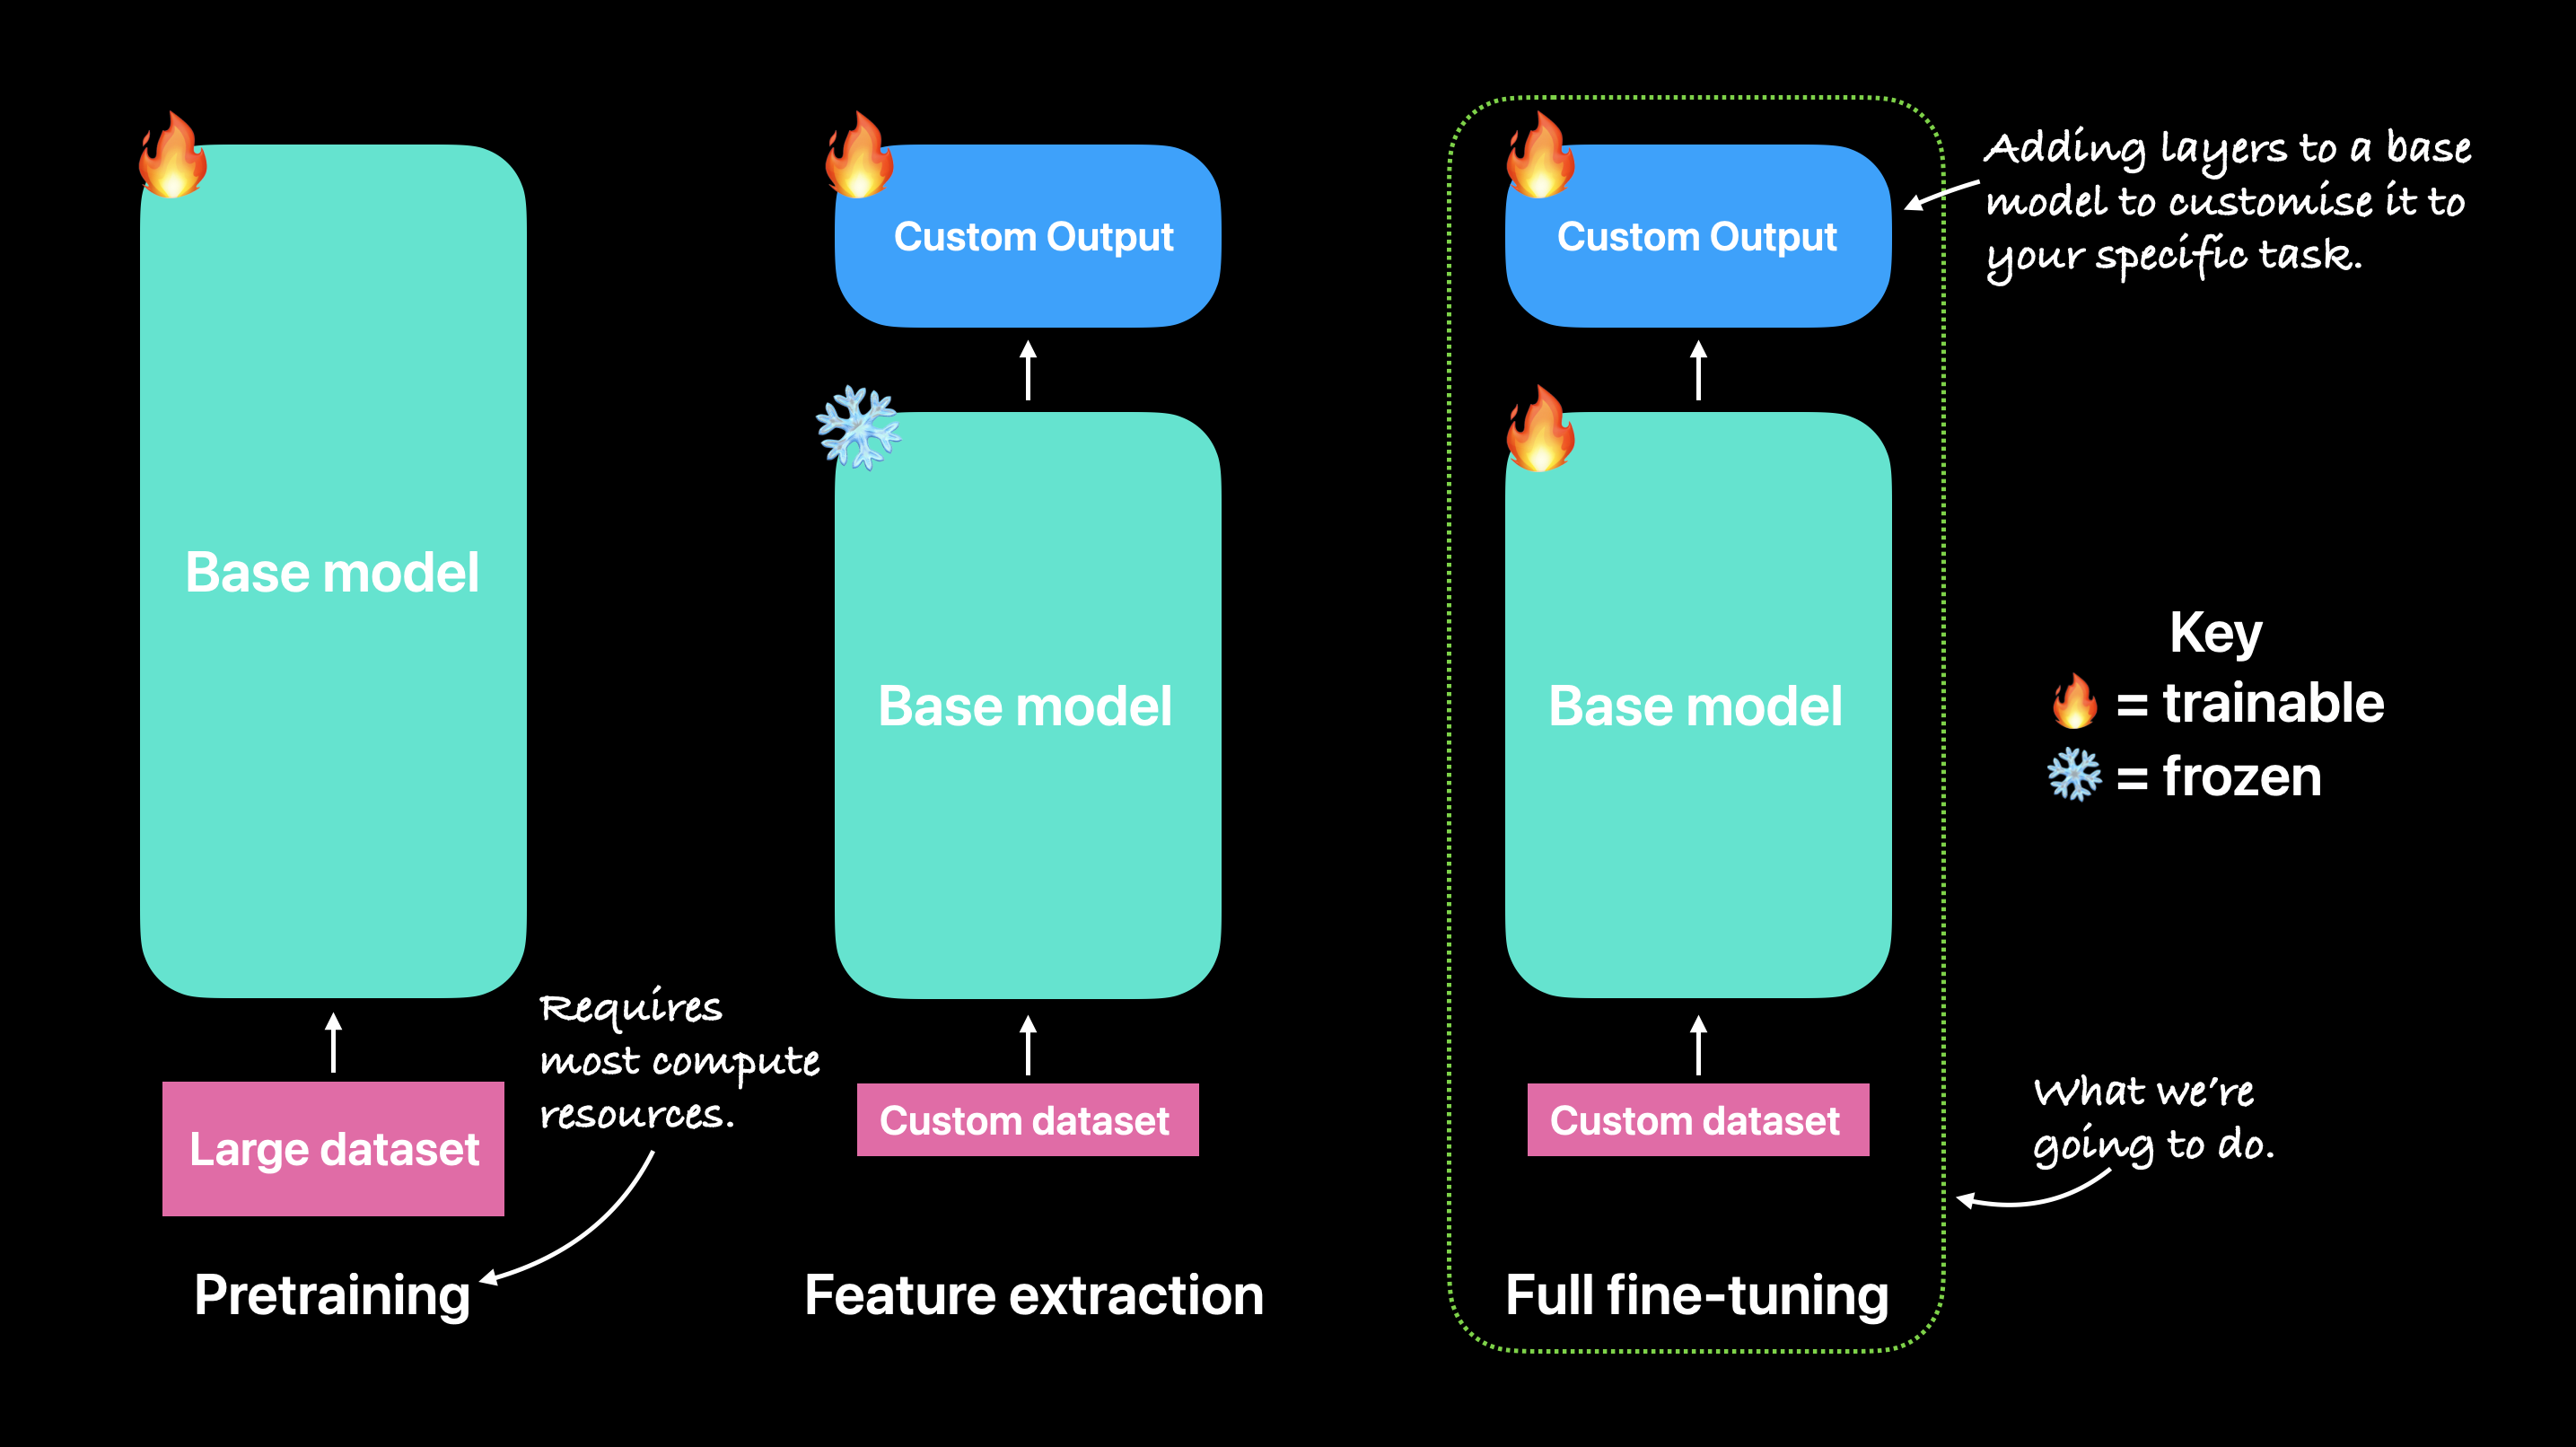

Various forms of training paradigms Above.
  * Typically you'll start with a model that has been pretrained on a large dataset.
    * For example, a base model could be one that has read all of Wikipedia + 1000's of books (like our DistilBert model) and has a good general representation of language data.
    * This representation can then be tailored to a specific use case by customizing the outputs and adjusting the representation slightly by feeding it custom data.
    * This process is often referred to as **fine-tuning.**
* In our case we will be performing **"Full fine-tuning"**.

## Why use transfer learning?
1. Can leverage an existing pre-trained neural network architecture **proven to work** on problems similar to our own
  * --> e.g. NLP specific tasks!
2. Can leverage a working network architecture which as **already learned patterns** on similar data to our own (often results in great results with less data!).

## Workflow for Model Training
1. Create and preprocess data ✅
2. Define model we'd like to use for our problem or see the "task guides" in HF transformers docs: https://huggingface.co/docs/transformers/en/tasks/sequence_classification
3. Define training arguments for training our model `transformers.TrainingArguments`
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically by the model.
4. Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model to our local machine or local notebook instance
  * Can also push to HF hub
7. Evaluate trained model by making and inspecting predictions on the test data (and our own custom data
8. Turn model into a shareable demo using Gradio

### A note about model customization
* To customize the model head, we pass these variables below:
  * 1) `num_labels`
  * 2) `id2label`
  * 3) `label2id`

In [49]:
## setup model
from transformers import AutoModelForSequenceClassification

## load model
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='distilbert/distilbert-base-uncased',#base model from HF
    num_labels=2, #classify into food or not food
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
## inspect model
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Summary:
* Our model is comprised of the following parts
  * 1. `embeddings` - are a form of learned representation of tokens. So if tokens are a direct mapping from token to number, embeddings are learned vector representation.
  * 2. `transformer` - our model architecture backbone, this has discovered patterns/relationships in the embeddings.
  * 3. **`classifier` - we need to customize this layer to suit our problem.**

Note: if you get input errors from passing a sample to a model, make sure the sample you pass to your model is formatted in the same way your model was trained on.
  * For example, if your model used a specific tokenizer, make sure to tokenize your text before passing it to the model!

Note: If we use the ** symbol it will unpack ALL keys in our dictionary

In [51]:
## unpack tokenized dataset
tokenized_dataset['train'][0]['input_ids']

[101,
 2275,
 1997,
 2132,
 19093,
 2872,
 2006,
 1037,
 4624,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Count Parameters in our Model
* Weights/parameters = small numeric opportunities for a model to learn patterns in data.
* **Most HF models are written in PyTorch**

In [52]:
## all params and layers of our model!
list(model.parameters())

[Parameter containing:
 tensor([[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
         [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
         [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
         ...,
         [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
         [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
         [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
           6.8312e-04,  1.5441e-02],
         [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
           2.9753e-02, -5.3247e-03],
         [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
           1.8741e-02, -7.3140e-03],
         ...,
         [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
           4.3435e-04, -2.6949e-02],
         [ 2.1687e-02, -6.0216e-03,  1.4736e-02,  

In [53]:
## count params in model
def count_params(model):
  """
  Count parameters of a PyTorch model.
  """
  ## sum model params if requires gradient descent during training
  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())

  return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}



## count params using function
count_params(model)


{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Summary:
* Wow a lot of parameters!
* Looks like model has around 67 million parameters and **all** are trainable.
* Note:
  * Generally the more params a model has, the more capacity it has to learn.
  * For comparison, models such as Llama 3 8B has 8 billion parameters.
* If you want the best possible performance, generally MORE PARAMETERS IS BETTER!
  * However, with more parameters requires more compute + time.
  * **You'll be surprised how well a smaller model can perform with specific data.**

In [54]:
8_000_000_000 / 67_000_000

119.40298507462687

Summary:
* Above we can see that an 8 billion param model takes 120 times the compute power than the model we are using which is 67 million parameters.

### Create a directory for saving models

In [55]:
# create model output directory
from pathlib import Path

# create models dir
models_dir = Path("models")
models_dir.mkdir(exist_ok=True) ## if exists already --> proceed

# Create model save name
model_save_name = "text_classifier_foot_not_food_distilbert-base-uncased"

# create model save path
model_save_dir = Path(models_dir, model_save_name)


# output model_save_dir
model_save_dir

PosixPath('models/text_classifier_foot_not_food_distilbert-base-uncased')

## Setting up training arguments (hyperparameters) with TrainingArguments
1. ✅ Create and preprocess data
2. ✅ Define model we'd like to use for our problem or see the "task guides" in HF transformers docs: https://huggingface.co/docs/transformers/en/tasks/sequence_classification
3. Define training arguments for training our model `transformers.TrainingArguments`
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically by the model.
  * HF training docs: https://huggingface.co/docs/transformers/en/main_classes/trainer
  * **Note: The `Trainer` class from HF simplifies having to write out the entire training loop in PyTorch**
4. Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model to our local machine or local notebook instance
  * Can also push to HF hub
7. Evaluate trained model by making and inspecting predictions on the test data (and our own custom data
8. Turn model into a shareable demo using Gradio

Notes:
* Some Parameters we are going to use:
  * 1. `output_dir`
  * 2. `learning_rate` - we will set this higher because we have a smaller dataset.
  * 3. `per_device_train_batch_size` - we will use 32 which is standard
  * 4. `per_device_eval_batch_size`
  * 5. `seed` - will allow similarity or the same result
  * 6. `load_best_model_at_end`
  * 7. `logging_strategy`
  * 8. `report_to` -- if using external experiment tracker such as Weights & Biases (not using this here)
  * 9. `push_to_hub` - auto save to HF hub at end of training
  * 10. `hub_token` - if you want to manually pass in HF token and not save as secret locally.
  * 11. `hub_private_repo` - depends on if your repo is private (e.g. a company or organization) or public -- defaults to public.

In [56]:
## training arguments
from transformers import TrainingArguments

#print where saving to
print(f"[INFO] Saving model checkpoints: {model_save_dir}")

#hyperparameters - preset
BATCH_SIZE=32


# create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001, #set higher for small dataset, smaller for larger dataset
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    eval_strategy='epoch', # values are: no, steps, epoch
    save_strategy='epoch', #save every epoch
    save_total_limit=3, #save only 3 versions of model
    use_cpu=False, #defaults to False
    seed=42,
    load_best_model_at_end=True,
    logging_strategy='epoch',
    report_to='none', #not reporting to external platform
    #hub_token=<put your token here>
    #push_to_hub=True ##if pushing to HF hub after training
    hub_private_repo=False #when uploading to Hugging Face hub, do you want repo to private or public (default=public)
)

[INFO] Saving model checkpoints: models/text_classifier_foot_not_food_distilbert-base-uncased


## Setting up an instance of Trainer
1. ✅ Create and preprocess data
2. ✅ Define model we'd like to use for our problem or see the "task guides" in HF transformers docs: https://huggingface.co/docs/transformers/en/tasks/sequence_classification
3. ✅ Define training arguments for training our model `transformers.TrainingArguments`
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically by the model.
  * HF training docs: https://huggingface.co/docs/transformers/en/main_classes/trainer
  * **Note: The `Trainer` class from HF simplifies having to write out the entire training loop in PyTorch**
4. Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model to our local machine or local notebook instance
  * Can also push to HF hub
7. Evaluate trained model by making and inspecting predictions on the test data (and our own custom data
8. Turn model into a shareable demo using Gradio

* Docs for `transformers.Trainer`
  * The Trainer class provides an API for feature-complete training in PyTorch, and it supports distributed training on multiple GPUs/TPUs, mixed precision for NVIDIA GPUs, AMD GPUs, and torch.amp for PyTorch.
  * Trainer goes hand-in-hand with the `TrainingArguments` class, which offers a wide range of options to customize how a model is trained.
  * Together, these two classes provide a complete training API.
    * Docs: https://huggingface.co/docs/transformers/en/main_classes/trainer

In [57]:
## imports for eval metric
import evaluate
import numpy as np
from typing import Tuple ## type hint for function


## setup acc metric
accuracy_metric = evaluate.load('accuracy')

## create function to evaluate
def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes accuracy of model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [58]:
## this is the compute_accuracy function
compute_accuracy

<function __main__.compute_accuracy(predictions_and_labels: Tuple[<built-in function array>, <built-in function array>])>

In [59]:
## instance of Trainer
from transformers import Trainer

# setup Trainer instance
trainer = Trainer(
    model=model, #pre-trained distilbert model
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer, # pre-trained tokenizer
    compute_metrics=compute_accuracy, #accuracy function from above

)

## trainer instance
trainer

## Train the model by calling `Trainer.train()`
1. ✅ Create and preprocess data
2. ✅ Define model we'd like to use for our problem or see the "task guides" in HF transformers docs: https://huggingface.co/docs/transformers/en/tasks/sequence_classification
3. ✅ Define training arguments for training our model `transformers.TrainingArguments`
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically by the model.
  * HF training docs: https://huggingface.co/docs/transformers/en/main_classes/trainer
  * **Note: The `Trainer` class from HF simplifies having to write out the entire training loop in PyTorch**
4. ✅ Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model to our local machine or local notebook instance
  * Can also push to HF hub
7. Evaluate trained model by making and inspecting predictions on the test data (and our own custom data
8. Turn model into a shareable demo using Gradio

* Docs for `transformers.Trainer`
  * The Trainer class provides an API for feature-complete training in PyTorch, and it supports distributed training on multiple GPUs/TPUs, mixed precision for NVIDIA GPUs, AMD GPUs, and torch.amp for PyTorch.
  * Trainer goes hand-in-hand with the `TrainingArguments` class, which offers a wide range of options to customize how a model is trained.
  * Together, these two classes provide a complete training API.
    * Docs: https://huggingface.co/docs/transformers/en/main_classes/trainer

In [60]:
## testing why predictions + refs dont match expected format
input_predictions = np.array([[-1.2846918, 1.1948152 ]])
input_references = np.array([0])

# need to get max value from model output (the index) as this is the "most likely" label according to the model
# see np.argmax docs: https://numpy.org/doc/2.0/reference/generated/numpy.argmax.html
if len(input_predictions.shape) >= 2:
  input_predictions = np.argmax(input_predictions, axis=1)

input_predictions


array([1])

In [61]:
## test out
compute_accuracy(predictions_and_labels=(input_predictions, input_references))

{'accuracy': 0.0}

In [62]:
len(input_predictions.shape)

1

### Train the model

In [63]:
## run trainer.train
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.338000,0.034074,1.000000
2,0.016900,0.004406,1.000000
3,0.003300,0.001618,1.000000
4,0.001600,0.000942,1.000000
5,0.001000,0.000690,1.000000
6,0.000800,0.000574,1.000000
7,0.000700,0.000512,1.000000
8,0.000600,0.000478,1.000000
9,0.000600,0.000460,1.000000
10,0.000600,0.000454,1.000000


In [64]:
results.metrics

{'train_runtime': 537.0591,
 'train_samples_per_second': 3.724,
 'train_steps_per_second': 0.13,
 'total_flos': 18110777160000.0,
 'train_loss': 0.03641113697418145,
 'epoch': 10.0}

In [65]:
# inspect training metrics
for key, value in results.metrics.items():
  print(f"{key} : {value}")

train_runtime : 537.0591
train_samples_per_second : 3.724
train_steps_per_second : 0.13
total_flos : 18110777160000.0
train_loss : 0.03641113697418145
epoch : 10.0


Summary:
* `flos` is floating point operations per second.
* The `train_loss` was quite low which is good.
* The model overall did not take long to train.

### Save model for later use

> **Note:** If you are saving a model to Google Colab, note that it will disappear from your instance when it disconnects. So we need to save it.

In [66]:
## save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/text_classifier_foot_not_food_distilbert-base-uncased


### Inspect the model training metrics
* We can get the model training history.

In [67]:
## get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[:-1]

# View first 3
trainer_history_metrics[:3]

[{'loss': 0.338,
  'grad_norm': 0.8187203407287598,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.0340740792453289,
  'eval_accuracy': 1.0,
  'eval_runtime': 2.721,
  'eval_samples_per_second': 18.376,
  'eval_steps_per_second': 0.735,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0169,
  'grad_norm': 0.09911182522773743,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14}]

In [68]:
## extract training metrics
import pprint

# Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through our metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# Show first item from each
print(f"First item in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\nFirst two items in eval epochs:")
pprint.pprint(trainer_history_eval_set[:2])

First item in training set:
[{'epoch': 1.0,
  'grad_norm': 0.8187203407287598,
  'learning_rate': 9e-05,
  'loss': 0.338,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.09911182522773743,
  'learning_rate': 8e-05,
  'loss': 0.0169,
  'step': 14}]

First two items in eval epochs:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.0340740792453289,
  'eval_runtime': 2.721,
  'eval_samples_per_second': 18.376,
  'eval_steps_per_second': 0.735,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.004405945539474487,
  'eval_runtime': 3.0535,
  'eval_samples_per_second': 16.375,
  'eval_steps_per_second': 0.655,
  'step': 14}]


### Taking a look at loss curves

* Loss curves = a good visualization of your model's performance over time.
* Ideally, loss curves will trend downwards.

See more here: https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

In [69]:
## create pandas df for training and eval metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

## trainer df head - train data
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.034074,1.0,2.7210,18.376,0.735,1.0,7
1,0.004406,1.0,3.0535,16.375,0.655,2.0,14
2,0.001618,1.0,2.7558,18.143,0.726,3.0,21
3,0.000942,1.0,2.7384,18.259,0.730,4.0,28
4,0.000690,1.0,3.7134,13.465,0.539,5.0,35


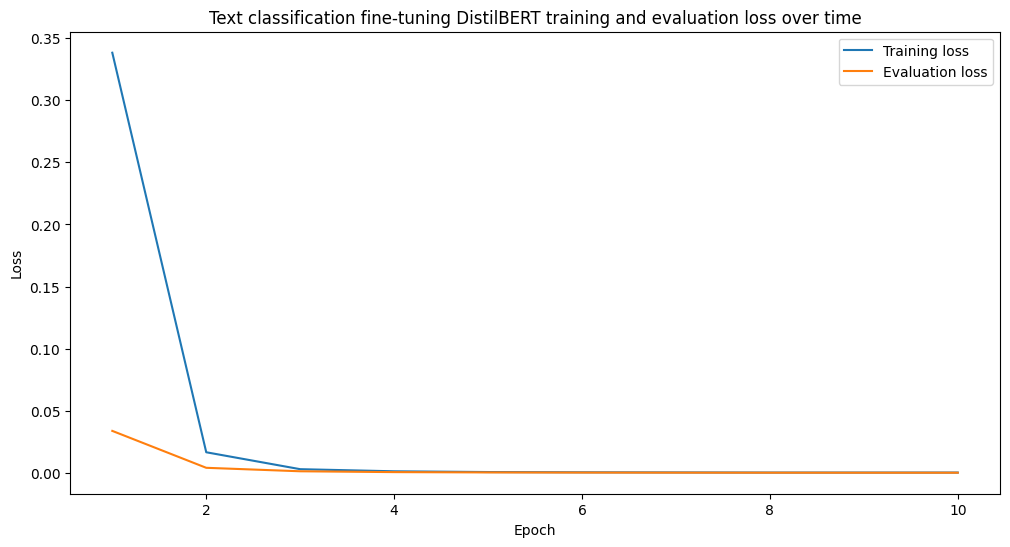

In [70]:
# plot loss curves
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(trainer_history_train_df['epoch'], trainer_history_train_df['loss'], label="Training loss")
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label="Evaluation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Text classification fine-tuning DistilBERT training and evaluation loss over time")
plt.legend()
plt.show();

Summary:
* This is an ideal result.
* If your eval loss was higher than our trainingloss than our model would be overfitting.
* Good overview of both: https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

### Pushing model to huggingface hub
* Why do this?
  * To share the model.
  * Other people can use.
  * We can keep an active history and version control.

* To write to Hugging Face:
  * If google colab: setup "token" with "read and write" access: https://huggingface.co/docs/diffusers/en/using-diffusers/push_to_hub
  * If on local machine: setup `huggingface-cli`: https://huggingface.co/docs/huggingface_hub/en/guides/cli


* To save to the Hugging Face Hub, we can use the `Trainer.push_to_hub` method: https://huggingface.co/docs/transformers/en/model_sharing


In [ ]:
from huggingface_hub import notebook_login, logout

logout() # Log out first
notebook_login() # Then log in again

Not logged in!


In [ ]:
# save our model to the Hugging Face hub
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model",
    token = "<YOUR_TOKEN_HERE>"
)
# print if successful upload
print(f"[INFO] Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

[INFO] Model successfully uploaded to the Hugging Face Hub with URL: https://huggingface.co/NLUdoctor525/text_classifier_foot_not_food_distilbert-base-uncased/tree/main/


## Making and evaluting predictions on the test data
1. ✅ Create and preprocess data
2. ✅ Define model we'd like to use for our problem or see the "task guides" in HF transformers docs: https://huggingface.co/docs/transformers/en/tasks/sequence_classification
3. ✅ Define training arguments for training our model `transformers.TrainingArguments`
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically by the model.
  * HF training docs: https://huggingface.co/docs/transformers/en/main_classes/trainer
  * **Note: The `Trainer` class from HF simplifies having to write out the entire training loop in PyTorch**
4. ✅ Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. ✅ Train the model by calling `Trainer.train()`
6. ✅ Save the model to our local machine or local notebook instance
  * Can also push to HF hub
7. Evaluate trained model by making and inspecting predictions on the test data (and our own custom data
8. Turn model into a shareable demo using Gradio


**Note:**
* Evaluating a model is just as important as training a model.

We can make predictions on test data using the `Trainer.predict` method: https://huggingface.co/docs/transformers/en/main_classes/trainer

In [71]:
tokenized_dataset['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [72]:
tokenized_dataset['test']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [73]:
# perorm preds on test data
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics


print(f"[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0004540553782135248,
 'test_accuracy': 1.0,
 'test_runtime': 4.0699,
 'test_samples_per_second': 12.285,
 'test_steps_per_second': 0.491}

Summary:
* We can see that using a small dataset we trained a model that predicted 100% of the test set. Obviously a larger dataset would not be as accurate.

> **Note:** If you want a good evaluation method, make predictions on your entire test dataset, then index on the predictions which are wrong but have high prediction probability.
* For example, get the top 100 to 100,000 and go through all examples where the model's prediction had high probability but was incorrect --> this often leads to great insights into your data.

### Lets get predicted probabilities and evaluate by hand using PyTorch


In [74]:
# model outputs raw logits
predictions_all.predictions[0]

array([-3.729045,  4.017522], dtype=float32)

In [75]:
# softmax gets all raw logit values between 0 & 1 and total of values sum to 1
# This is whats known as a "prediction probability", as in model is assigning this value to how "likely" the prediction is given the sample

torch.softmax(torch.tensor(predictions_all.predictions[0]), dim=0)

tensor([4.3204e-04, 9.9957e-01])

In [76]:
## predicted logits (raw output of model) -> prediction probs with torch.softmax -> predicted labels
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities with torch.softmax
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = tokenized_dataset['test']['label']

# 4. Compute prediction labels to true labels and get test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)


print(f"[INFO] Test accuracy: {test_accuracy*100}")

[INFO] Test accuracy: 100.0


In [77]:
predictions_all.label_ids

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1])

### Exploring our models prediction probabilities
* Its a very good way to eval a model by sorting prediction probs and seeing where the model went wrong.

In [78]:
# Make a DataFrame of test preds
test_predictions_df = pd.DataFrame({
    "text": dataset['test']['text'],
    'true_label': true_labels,
    'pred_label': pred_labels,
    'pred_prob': torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999568
1,Red brick fireplace with a mantel serving as a...,0,0,0.999506
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999567
3,Set of mugs hanging on a hook,0,0,0.999535
4,Standing floor lamp providing light next to an...,0,0,0.999523


In [79]:
# show 10 examples with low prediction probability
test_predictions_df.sort_values('pred_prob', ascending=True).head(10)

,text,true_label,pred_label,pred_prob
43,Set of muffin tins stacked together,0,0,0.999435
17,"Relaxing on the porch, a couple enjoys the com...",0,0,0.999471
1,Red brick fireplace with a mantel serving as a...,0,0,0.999506
39,A close-up of a woman practicing yoga in the l...,0,0,0.999517
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999517
27,A close-up of a cat lounging on a windowsill w...,0,0,0.999519
23,Yoga mat rolled up and ready in a corner,0,0,0.999520
4,Standing floor lamp providing light next to an...,0,0,0.999523
12,A boy giving his dog a bath in the backyard,0,0,0.999526
29,Set of stainless steel utensils arranged on a ...,0,0,0.999526


### Making and inspecting predictions on custom text data

In [80]:
local_model_path = "/content/models/text_classifier_foot_not_food_distilbert-base-uncased"

huggingface_model_path = "adamNLP/text_classifier_foot_not_food_distilbert-base-uncased" # if you have a model on hf

### Discussing ways to make predictions (inference)
* Note: Whenever you hear the word "inference" it means to use a model to make predictions on data.

Two main ways to perform inference:

1. **Pipeline mode** - Using `tranformers.pipeline` to load ourmodel and perform text classification. See the docs: https://huggingface.co/docs/transformers/en/main_classes/pipelines

2. **PyTorch mode** - Using a combination of `transformers.AutoTokenizer` and `transformers.AutoModelForSequenceClassification` and passing each our target model name.

Each mode supports:
1. **Predictions one at a time**
  * Fast but can be slower with many many samples!
  * Helpful for a comment system and comments happen sporadically, to predict whether the comment was "spam" or "not spam". (binary text classification)
2. **Batches of predictions at a time**
  * faster but up to a point
    * e.g. say you predict on 32 samples at a time, this may be way faster than one at a time but if you go to 128 at a time, you may not see anymore speedups!
  * Helpful for when you have a large static database or many samples coming in at once.

In [81]:
# setup our device for making predictions
# Note: generally the faster the hardware accelerator the faster the predictions
# For example, if you have a dedicated GPU, you should use it over CPU

## device agnostic code
def set_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built(): #https://pytorch.org/docs/main/notes/mps.html
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
  return device


## setup device
DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cpu


### Making predictions with pipeline mode

See docs: https://huggingface.co/docs/transformers/en/main_classes/pipelines



In [82]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [82]:
import torch
from transformers import pipeline

# set the batch size -- batch size depends on your hardware size
BATCH_SIZE = 32 # reminder: prediction speed often increases with higher batch size (e.g. 1 --> 32 but can saturate at even higher batch sizes)

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task='text-classification', ## prediction task
                                    model=local_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)


## pipeline
food_not_food_classifier

In [83]:
## test pipeline
test_custom_sent = "My local coffee shop sells donuts."
food_not_food_classifier(test_custom_sent)

[[{'label': 'food', 'score': 0.7940306067466736}]]

Summary:
* This is an interesting test case of the model because it isn't directly about food, it does have food in the sentence though.
* This is a good reason to always test your model on various use cases --> this may be an exampl where we have to train our model on more data with samples like this for it to understand that this is actually food mentioned here.


In [84]:
## test pipeline
test_not_food_sent = "A red race car going around the track."
food_not_food_classifier(test_not_food_sent)

[[{'label': 'not_food', 'score': 0.9994781613349915}]]

In [85]:
## test pipeline
test_not_food_sent = "A 2014 subaru forrester."
food_not_food_classifier(test_not_food_sent)

[[{'label': 'not_food', 'score': 0.9989333748817444}]]

We can also use our pipelin with a model direct from huggingface
* First we need to delete our pipeline to init a new one.

In [87]:
# delete pipeline
#del pipeline
del foot_not_food_classifier

NameError: name 'foot_not_food_classifier' is not defined

In [86]:
# use pipeline with a model from HF
from transformers import pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=huggingface_model_path,
                                    device=DEVICE,
                                    top_k=1, #num samples
                                    batch_size=BATCH_SIZE)

food_not_food_classifier(test_not_food_sent)

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[[{'label': 'not_food', 'score': 0.9978469610214233}]]

Summary:
* We were able to download the model we just custom trained from huggingface and make a prediction!

### Making multiple predictions at the same time with batch prediction

In [89]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "K. Bacon is a really good actor",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9927749633789062}],
 [{'label': 'not_food', 'score': 0.9976807832717896}],
 [{'label': 'not_food', 'score': 0.995797872543335}],
 [{'label': 'not_food', 'score': 0.9980568289756775}],
 [{'label': 'not_food', 'score': 0.996538519859314}],
 [{'label': 'not_food', 'score': 0.9963502883911133}],
 [{'label': 'not_food', 'score': 0.9951831698417664}],
 [{'label': 'food', 'score': 0.9991127848625183}],
 [{'label': 'not_food', 'score': 0.9991756081581116}],
 [{'label': 'food', 'score': 0.5046986937522888}]]

Summary:
* Very cool the model was able to distinguish that "K. Bacon" is kevin bacon and not bacon the food.
* Interestingly enough, the "fake food" sentence is classified as food. Something we may want to consider if this should be classified as food or not? --- its not edible food.

In [90]:
## synthetic data created a list of food image captions using Claude 3
# Food captions
food_captions = [
    "A mouth-watering cheeseburger with crispy fries on the side.",
    "A vibrant bowl of mixed greens topped with grilled chicken and avocado.",
    "Freshly baked croissants dusted with powdered sugar on a rustic wooden board.",
    "A steaming cup of aromatic coffee with swirls of frothy milk.",
    "Juicy slices of watermelon arranged on a platter, perfect for a hot summer day.",
    "A delectable plate of spaghetti carbonara, with crispy bacon and a creamy sauce.",
    "A beautifully arranged charcuterie board with a variety of cured meats, cheeses, and olives.",
    "Flaky, golden-brown empanadas filled with savory beef and vegetable filling.",
    "A towering stack of fluffy pancakes drizzled with maple syrup and topped with fresh berries.",
    "A vibrant display of colorful macarons in various flavors, lined up in perfect rows."
]

food_not_food_classifier(food_captions)

[[{'label': 'food', 'score': 0.9994138479232788}],
 [{'label': 'food', 'score': 0.9994262456893921}],
 [{'label': 'food', 'score': 0.9988707900047302}],
 [{'label': 'food', 'score': 0.9993684887886047}],
 [{'label': 'food', 'score': 0.9987531900405884}],
 [{'label': 'food', 'score': 0.9994291663169861}],
 [{'label': 'food', 'score': 0.999423623085022}],
 [{'label': 'food', 'score': 0.999427855014801}],
 [{'label': 'food', 'score': 0.999413013458252}],
 [{'label': 'food', 'score': 0.9992861151695251}]]

Observation: All are correctly predicted as food.

In [91]:
# synthetic Non-food captions created with Claude 3
not_food_captions = [
    "A sleek and modern laptop with a vibrant display showcasing lines of code.",
    "A stunning sunset over a tranquil beach, with waves gently lapping at the shore.",
    "An intricate origami sculpture made from delicate paper folds.",
    "A cozy reading nook with a plush armchair and a stack of books.",
    "A vintage typewriter sitting on a wooden desk, ready for the next literary masterpiece.",
    "A carefully curated collection of houseplants in stylish ceramic pots.",
    "A vibrant abstract painting with bold brushstrokes and a splash of colors.",
    "A charming vintage camera with a leather strap and polished metal details.",
    "A sleek and minimalist interior design with clean lines and muted tones.",
    "A whimsical handmade quilt featuring intricate patterns and vibrant colors."
]

# run inference pipeline
food_not_food_classifier(not_food_captions)

[[{'label': 'not_food', 'score': 0.9995455145835876}],
 [{'label': 'not_food', 'score': 0.9995176792144775}],
 [{'label': 'not_food', 'score': 0.9991164803504944}],
 [{'label': 'not_food', 'score': 0.9995757937431335}],
 [{'label': 'not_food', 'score': 0.999589741230011}],
 [{'label': 'not_food', 'score': 0.9995282888412476}],
 [{'label': 'not_food', 'score': 0.9992740750312805}],
 [{'label': 'not_food', 'score': 0.9995602965354919}],
 [{'label': 'not_food', 'score': 0.99946528673172}],
 [{'label': 'not_food', 'score': 0.9994542002677917}]]

Observation: All are correctly predicted as NOT FOOD.

In [92]:
## synthetic data generated with Claude 3 -- 10 captions that might be misled to think they are food but arent
confusing_not_food_captions = [
    "A canvas of rich colors and textures that resemble a delicious dessert, but it's actually an abstract painting.",
    "Perfectly spherical shapes arranged in rows, looking like fruits, but they're actually decorative glass balls.",
    "A steaming hot creation with intricate swirls and designs, appearing like latte art, but it's a decorative wax sculpture.",
    "Vibrant hues and intricate patterns, resembling a colorful spice blend, but it's actually a close-up of a handmade rug.",
    "Glistening droplets on a smooth surface, looking like a delectable syrup, but it's actually water droplets on a car's hood.",
    "A towering structure with layers of different materials, resembling a decadent cake, but it's an architectural model.",
    "Crinkled and textured surfaces, appearing like the crispy exterior of a baked good, but it's actually a pile of fallen autumn leaves.",
    "Delicate threads intertwined in an intricate pattern, looking like homemade pasta, but it's a macrame wall hanging.",
    "Glossy and smooth surfaces with playful shapes, seeming like a collection of candies, but they're actually decorative soap bars.",
    "A fusion of earthy tones and organic forms, appearing like a display of assorted vegetables, but it's a pottery sculpture."
]
food_not_food_classifier(confusing_not_food_captions)

[[{'label': 'food', 'score': 0.9982979893684387}],
 [{'label': 'food', 'score': 0.9992015957832336}],
 [{'label': 'food', 'score': 0.7781825661659241}],
 [{'label': 'food', 'score': 0.9981825351715088}],
 [{'label': 'food', 'score': 0.5086601972579956}],
 [{'label': 'not_food', 'score': 0.9978637099266052}],
 [{'label': 'food', 'score': 0.9992115497589111}],
 [{'label': 'not_food', 'score': 0.8175725936889648}],
 [{'label': 'food', 'score': 0.9985804557800293}],
 [{'label': 'food', 'score': 0.9993207454681396}]]

Observation
* We can see that the model was confused and predicted food for a lot of them even though they aren't food. We will have to fix this in our data training.

**Note: Best practices in machine learning would be to add some of these sythetic samples above where the model didnt perform as well to our training data with labels.**
* For now we won't do that but a good future consideration for building more robust models.

### Time our model across larger sample sizes
* First time it making predictions one at a time.
* Then lets do it in batches and compare.

In [ ]:
import time

# create 1000 sentences
sentences_1000 = sentences * 100 ## creates 1000 sentences

#len(sentences_1000)

# Time how long it takes to make predictions on all sentences (one at a time)
print(f'[INFO] Number of sentences: {len(sentences_1000)}')
start_time_one_at_a_time = time.time() ## start timing
for sentence in sentences_1000:
  # make a prediction
  food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time() ## end timing


## calculate timing and print outputs
total_time_one_at_a_time = end_time_one_at_a_time - start_time_one_at_a_time ## calculate total time
avg_time_per_pred = total_time_one_at_a_time / len(sentences_1000) ## avg time
print(f"[INFO] Total time for making predictions on {len(sentences_1000)} samples one at a time: {total_time_one_at_a_time}s")
print(f"[INFO] Avg time per prediction one at a time: {avg_time_per_pred}s")

[INFO] Number of sentences: 1000
[INFO] Total time for making predictions on 1000 samples one at a time: 77.0908260345459s
[INFO] Avg time per prediction one at a time: 0.0770908260345459s


In [ ]:
## let's now use pipeline in batches
for i in [10, 100, 1000, 10_000]:
  sentences_big = sentences * i
  print(f"[INFO] Number of sentences: {len(sentences_big)}")

  start_time = time.time() ## start timing
  # Predict on all sentences in batch mode
  food_not_food_classifier(sentences_big)
  end_time = time.time() # end timing

  total_time_per_all_sentences_batch_mode = end_time - start_time #calculate total time
  avg_time_per_sentence_batch_mode = total_time_per_all_sentences_batch_mode / len(sentences_big) #avg time

  print(f"[INFO] Inference time for {len(sentences_big)} sentences batch mode: {round(total_time_per_all_sentences_batch_mode, 6)}")
  print(f"[INFO] Avg inference time per sentence: {round(avg_time_per_sentence_batch_mode, 8)}")
  print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences batch mode: 3.295752
[INFO] Avg inference time per sentence: 0.03295752

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences batch mode: 36.954539
[INFO] Avg inference time per sentence: 0.03695454

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences batch mode: 385.287733
[INFO] Avg inference time per sentence: 0.03852877

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences batch mode: 3623.908935
[INFO] Avg inference time per sentence: 0.03623909



Summary:
* **BATCHING** when in doubt works well for **LARGE** datasets as we can see above it was quite fast and even faster than one at a time.

### Making predictions with PyTorch
* More flexible prediction ability.

* Steps with PyTorch predictions:

1. Create the tokenizer with `AutoTokenizer`.
2. Create the model with `AutoModel (`AutoModelForSequenceClassification`).
3. Tokenize text with 1.
4. Make prediction with 2
5. Format prediction

In [87]:
from transformers import AutoTokenizer

# Setup model path - can be local path or huggingface model path
model_path = "adamNLP/text_classifier_foot_not_food_distilbert-base-uncased"

# create an example to predict on
sample_food_text = "A delicious photo of a plate of scrambled eggs, toast and bacon"

# prepare the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_food_text,
                   return_tensors="pt") # pytorch tensors
inputs


{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 15174,  1998, 11611,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [88]:
## create model
from transformers import AutoModelForSequenceClassification


# load text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [89]:
import torch


model.eval()
# with torch.no_grad()
with torch.inference_mode(): #inference mode for model
  outputs = model(**inputs) ## '**' means input all of dictionary keys as named arguments/parameters
  outputs_verbose = model(input_ids=inputs['input_ids'],
                  attention_mask=inputs['attention_mask'])

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-3.8939,  3.4175]]), hidden_states=None, attentions=None)

In [90]:
outputs_verbose

SequenceClassifierOutput(loss=None, logits=tensor([[-3.8939,  3.4175]]), hidden_states=None, attentions=None)

In [91]:
## note: check the model.config to get which config you need
model.config.id2label

{0: 'not_food', 1: 'food'}

In [92]:
# Convert logits to prediction probability + label
# max of logits is --> index model predicts as most likely output
predicted_class_id = outputs.logits.argmax().item() #item so no longer tensor
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item() #inner tensor is dim = 1

## print
print(f"Text: {sample_food_text}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {prediction_probability}")

Text: A delicious photo of a plate of scrambled eggs, toast and bacon
Predicted label: food
Prediction probability: 0.9993324875831604


In [93]:
## pipeline prediction
food_not_food_classifier(sample_food_text)

[[{'label': 'food', 'score': 0.9993324875831604}]]

Summary:
* We were able to get the same prediction probability for the huggingface pipeline above and manually using PyTorch.
* Obviously using a pipeline eliminates some code and steps in the process.
* So far we were able to do this in multiple code cells but we can put this together into 1 function or class to make this more efficient and we will do this below.

## Putting it all together

Let's go end to end for text-classification project.

1. data import
2. model building
3. model evaluation
4. model saving

In [94]:
# 1. Import necessary packages
import pprint
from pathlib import Path #create file/folder

import numpy as np
import torch

import datasets #huggingface datasets
import evaluate

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2. Setup variables for model train and saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased" #original model from HF
MODEL_SAVE_DIR_NAME = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# 3. Create directory for saving models
print(f"[INFO] Creating directory for saving models: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and process data from huggingface hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(DATASET_NAME)

# create mapping from label2id and id2label
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

## create a function to map IDs to labels in the dataset
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

## map our preprocessing function to our dataset
dataset = dataset['train'].map(map_labels_to_number)

## split dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42) #test size 20%
#dataset

# 5. Import tokenizer and map to dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          clean_up_tokenization_spaces=True,
                                          use_fast=True) #fast version of tokenizer

## create function to tokenize text samples -- turn text into numbers
def tokenize_text(examples):
  return tokenizer(examples["text"],
                   padding=True,
                   truncation=True) #if samples above config.json max_size of 512 then change this

## tokenize dataset -- preprocess dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                 batched=True,
                                 batch_size=1000)


# 6. Set up evaluation metric
accuracy_metric = evaluate.load("accuracy")

## create function for evaluation
def compute_accuracy(predictions_and_labels):
  predictions, labels = predictions_and_labels

  ## we want the maximum of the output logits
  # model will output logits in form ([[item_1, item_2, item_3], [item_1, item_2, item_3]]) #depends on num of classes you have
  # but we want to compare labels which are in the format ([0, 0, 0, 0, 1])
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1) #reduce predictions to argmax

  return accuracy_metric.compute(predictions=predictions, references=labels)

# 7. Set up model
print(f"[INFO] Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
print(f"[INFO] Model loading complete!")

# setup TrainingArguments (these are hyperparams for our model)
# Hyperparameters = settings that we can set as developers
# Parameters = settings/weights our model learn on its own
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False, #if pushing to hub
    hub_private_repo=False, #Note this will make our model public by default

)
## Create trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Train model
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Save trained model (to local directory)
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Push model to huggingface hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model (putting it all together!)"
    #token="YOUR_TOKEN_HERE"
)
print(f"[INFO] Model upload complete, model available at: {model_upload_url}")

# 11. Evaluate model on test data
print(f"[INFO] Performing evaluation on test dataset...")
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics


print(f"[INFO] Prediction metrics on test data:")
pprint.pprint(prediction_metrics)

[INFO] Creating directory for saving models: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: mrdbourke/learn_hf_food_not_food_image_captions


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

[INFO] Loading model: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Model loading complete!
[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.409000,0.079845,1.000000
2,0.033600,0.008276,1.000000
3,0.005200,0.002324,1.000000
4,0.001900,0.001242,1.000000
5,0.001200,0.000881,1.000000
6,0.000900,0.000724,1.000000
7,0.014300,0.000619,1.000000
8,0.000700,0.000574,1.000000
9,0.000700,0.000551,1.000000
10,0.000600,0.000544,1.000000


[INFO] Model training complete, saving model to local path: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

[INFO] Model upload complete, model available at: https://huggingface.co/adamNLP/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Performing evaluation on test dataset...


[INFO] Prediction metrics on test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0005437003565020859,
 'test_runtime': 3.683,
 'test_samples_per_second': 13.576,
 'test_steps_per_second': 0.543}


In [95]:
#12. make sure the model works by testing it on a custom sample
from transformers import pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=model_save_dir,
                                    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
                                    top_k=1,
                                    batch_size=32,
                                    )
food_not_food_classifier("Yo!! We just trained a food not food text classifier in ~150 lines of code in a single colab cell!")

[[{'label': 'food', 'score': 0.9949973821640015}]]

In [96]:
food_not_food_classifier("Yo we just trained a text classifier in a single colab cell!!")

[[{'label': 'not_food', 'score': 0.9979998469352722}]]

Summary:
* We were able to train a text classifier model in a single colab cell.
* We also see that the model itself thinks that the mention of the word food means it is classified as "food". Again this is something we will have to fix with synthetic data for outlier cases like this.

## Turning model into demo
* We can turn this model into a machine learning model demo so others can utilize the model in a user interface in Gradio.
* This is a great way to build a demo on huggingface!
* We will use Gradio: https://www.gradio.app/
* HF spaces lets you share models and demos: https://huggingface.co/spaces


Gradio helps to create the workflow inputs --> model/function --> outputs

1. ✅ Create and preprocess data
2. ✅ Define model we'd like to use for our problem or see the "task guides" in HF transformers docs: https://huggingface.co/docs/transformers/en/tasks/sequence_classification
3. ✅ Define training arguments for training our model transformers.
  * TrainingArguments. These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically by the model.
  * HF training docs: https://huggingface.co/docs/transformers/en/main_classes/trainer
Note: The Trainer class from HF simplifies having to write out the entire training loop in PyTorch
4. ✅ Pass TrainingArguments to an instance of transformers.Trainer
5. ✅ Train the model by calling Trainer.train()
6. ✅ Save the model to our local machine or local notebook instance
  * Can also push to HF hub
7. ✅ Evaluate trained model by making and inspecting predictions on the test data (and our own custom data).
8. Turn model into a shareable demo using Gradio

### 10.1 Creating a function to perform inference
1. Take an input of string.
2. Setup a text classification pipeline.
3. Get the output from the pipeline.
4. Return the output from the pipeline in step 3 as a formatted dictionary with the format: `[{"label_1": probability_1, "label_2": probability_2}]`

In [97]:
from typing import Dict #data format

# 1. Create a function to create a string input to Gradio
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task="text-classification",
                                      model=local_model_path,
                                      batch_size=32,
                                      device="cuda" if torch.cuda.is_available() else "cpu",
                                      top_k=None) # top_k=None => return all possible labels
  # 3. get outputs from pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]

  # 4. Format output for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item["label"]] = item["score"]

  return output_dict

## test function
food_not_food_classifier(text="Yo we are building a local demo!")



{'not_food': 0.9976674914360046, 'food': 0.002332479227334261}

### Building a small Gradio demo to run locally
* Gradio chat interface docs: https://www.gradio.app/docs/gradio/chatinterface

In [98]:
# 1. Import gradio
import gradio as gr

# 2. Create gradio interface
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title="Food Not Food Classifier",
    description="A text classifier to determine if a sentence is about food or not.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error"],
              ["A plate of pancakes and strawberry icing"]]
)

# 3. Launch the interface
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://16253e9802a3cc6bcf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Making our demo publicly accessible
* There are 2 main ways to make our demo publicly accessible with Hugging Face spaces:

1. Manually - go to huggingface.co/spaces --> "create new space" --> add new files and publish

2. Programatically - we can use the hugging face hub python api API and add our files to a space with code.

To create a space programatically we're going to need 3 files:

1. `app.py` - This is the main app with functionality of our demo.

2. `requirements.txt` - These are the dependencies which our app will require.

3. `README.md` - This will explain what our project/demo is about. And will also add some metadata in YAML format.

To create these we will use the following file structure:

```
demos/
└── food_not_food_text_classifier/
    ├── app.py
    ├── README.md
    └── requirements.txt
```

### Making a directory to store our demo

In [99]:
from pathlib import Path

# Make directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifier demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

### Making an app.py file
* The `app.py` file will contain the main logic of the application.

* So when loaded to hugging face spaces, spaces will try to run `app.py` automatically.

* In our `app.py` file we want to:

1. Import packages.
2. Define our function to use our model (this will work with Gradio).
3. Create a demo with Gradio.
4. Run the demo with `demo.launch()`.

We can use built-in magic commands to do this.
* One of those commands is: `%%writefile`
* Docs: https://ipython.readthedocs.io/en/stable/interactive/magics.html

In [100]:
import os

# Define the directory path
directory_path = '/content/demos/food_not_food_text_classifier'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)


In [107]:
%%writefile /content/demos/food_not_food_text_classifier/app.py
# 1. Import required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define our function to use with our model.
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task="text-classification",
                                      model="adamNLP/learn_hf_food_not_food_text_classifier-distilbert-base-uncased",
                                      batch_size=32,
                                      device="cuda" if torch.cuda.is_available() else "cpu",
                                      top_k=None) # top_k=None => return all possible labels
  # 3. get outputs from pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]

  # 4. Format output for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item["label"]] = item["score"]

  return output_dict

# 3. Create a Gradio interface -- we can use markdown text to create a description field
description = """
A text classifier to determine if a sentence is about food or not food.

Fine-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) a [dataset of LLM generated food/not_food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions)
"""

## create demo
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title="🍕🚫🥑 Food or Not Food Text Classifier",
    description=description,
    examples=[["I whipped up a fresh batch of code, but it seems to have syntax error"],
              ["A plate of waffles and bluberry syrup"]]
)
# 4. Launch interface -- def Main function
if __name__ == "__main__":
  demo.launch()

Overwriting /content/demos/food_not_food_text_classifier/app.py


### Making a README.md file

* This file is in markdown format with a special YAML block at top.

* The YAML block at the top is used for metadata + settings.

In [108]:
%%writefile /content/demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji: 🍕🚫🍔
colorFrom: blue
colorTo: yellow
sdk: gradio
sdk_version: 5.4.0
app_file: app.py
pinned: false
license: apache-2.0
---
# 🍕🚫🍔 Food Not Food Text Classifier

Demo to showcase a text classifier to determine if a sentence is about food or not food.

DistilBERT model fine-tuned on a small synthetic dataset of [250 generated food/not_food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions)



Overwriting /content/demos/food_not_food_text_classifier/README.md


### Making a requirements file

* This file is going to tell our Hugging FaceSpace which versions/packages to utilize.

* If we don't create this file, we may get an error such as:

```
===== Application Startup at 2024-06-13 05:37:21 =====

Traceback (most recent call last):
  File "/home/user/app/app.py", line 1, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
```

In [109]:
%%writefile /content/demos/food_not_food_text_classifier/requirements.txt
gradio==5.4.0
torch
transformers

Overwriting /content/demos/food_not_food_text_classifier/requirements.txt


Summary:
* You could manually upload these files to your hugging face space, but we will upload them using the hugging face API.

### Uploading our demo to Hugging Face Spaces

To do so, we'll use the:
* Hugging Face Hub Python API: https://huggingface.co/docs/huggingface_hub/index
* Hugging Face with git: https://huggingface.co/docs/hub/index

To get our demo on HF spaces, we can do following:
1. Import necessary functions from HF Python API
2. Define what we want to upload
3. Create a repo: https://huggingface.co/docs/huggingface_hub/guides/repository
4. Get the name of our repo from upload: https://huggingface.co/docs/huggingface_hub/main/en/package_reference/hf_api#huggingface_hub.HfApi.get_full_repo_name
5. Upload contents of our `content/demos/food_not_food_text_classifier/` directory to Hugging Face Hub repo: https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-file
6. Hope it all works and inspect the results!

In [110]:
# 1. Import required methods for uploading to HF hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)
# 2. Define parameters to use for uploading to our space
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "/content/demos/food_not_food_text_classifier"
HF_TARGET_SPACE_NAME = "hf_food_not_food_text_classifier_with_distilbert_demo"
HF_REPO_TYPE = "space"
HF_SPACE_SDK = "gradio"
# HF_TOKEN = "<your token here>"

# 3. Create a Space repo on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN,
    repo_type=HF_REPO_TYPE,
    private=False, #set to true if want repo to be private
    space_sdk=HF_SPACE_SDK,
    exist_ok=True

)
# 4. Get full repo name(e.g. {username}/{repo_name})
hf_full_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face hub repo name: {hf_full_repo_name}")

# 5. Upload demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {hf_full_repo_name}")
folder_upload_url = upload_folder(
    repo_id=hf_full_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".",
    #token=HF_TOKEN,
    repo_type=HF_REPO_TYPE,
    commit_message="Upload food not food text classifier demo from notebook"


)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: hf_food_not_food_text_classifier_with_distilbert_demo
[INFO] Full Hugging Face hub repo name: adamNLP/hf_food_not_food_text_classifier_with_distilbert_demo
[INFO] Uploading /content/demos/food_not_food_text_classifier to repo: adamNLP/hf_food_not_food_text_classifier_with_distilbert_demo
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/adamNLP/hf_food_not_food_text_classifier_with_distilbert_demo/tree/main/.


# Summary
* We were able to train a custom model on food not food synthetic generated labels to classify text as food or not food.
* The model we trained though was on a smaller dataset so we may have to in the future enhance the training data with more samples.

### Embedding our Hugging Face Space

In [113]:
from IPython.display import HTML

# You can get embeddable HTML code for your demo by clicking the "Embed" button on the demo page
HTML(data='''
<iframe
    src="https://adamnlp-hf-food-not-food-text-classifier-with-di-550f108.hf.space"
    frameborder="0"
    width="850"
    height="450"
></iframe>
''')